In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans

import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, \
                            silhouette_score, silhouette_samples

from sklearn.manifold import TSNE

from sklearn.decomposition import PCA

import warnings
from sklearn.exceptions import ConvergenceWarning

# Корисні функції

In [4]:
def count_null_percentage(data):
    null_count       = data.isnull().sum()
    null_percentage = round((data.isnull().sum()/df.shape[0]) * 100, 2)
    
    null_df = pd.DataFrame({'column_name' : data.columns,
                            'null_count' : null_count,
                            'null_percentage': null_percentage})
    
    null_df.reset_index(drop = True, inplace = True)
    null_df.sort_values(by = 'null_percentage', ascending = False)
    
    return null_df

In [5]:
def count_stat(df, column, col_type):
    if col_type == 'object':
        value_c = df[column].value_counts()
        print(value_c)
        
        plt.figure(figsize = (10,5))
        sns.countplot(data = df, x = column)
        plt.xticks(rotation = 90)
        plt.show()

    else:
        sns.boxplot(df[column])
        plt.show()

        mean = df[column].mean()
        mode = df[column].mode()[0]
        median = df[column].median()

        print(f'Mean: {mean} \nMode: {mode} \nMedian: {median}' )

In [6]:
def get_f1_score(target, preds, name = ''):
    f1_score_ = f1_score(target, preds, pos_label='Yes')

    print(f"F1 score {name}: {f1_score_:.2f}%")

In [7]:
def predict_and_plot(y_train, y_test, y_train_pred, y_test_pred):
    plt.figure(figsize = (10, 3))

    accuracy_train = accuracy_score(y_train, y_train_pred)
    print("Training accuracy: {:.2f}%".format(accuracy_train * 100))
    get_f1_score(y_train, y_train_pred, 'Training')

    accuracy_test = accuracy_score(y_test, y_test_pred)
    print("Test accuracy: {:.2f}%".format(accuracy_test * 100))
    get_f1_score(y_test, y_test_pred, 'Test')

    plt.subplot(1, 2, 1)
    cf_train = confusion_matrix(y_train, y_train_pred, normalize = 'true')
    sns.heatmap(cf_train, annot = True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Training Confusion Matrix');

    plt.subplot(1, 2, 2)
    cf_train = confusion_matrix(y_test, y_test_pred, normalize = 'true')
    sns.heatmap(cf_train, annot = True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Test Confusion Matrix');

In [8]:
def get_report(targets_train, preds_train, targets_test, preds_test):
    print('Training')
    print(classification_report(targets_train, preds_train, digits = 4))
    print('\nTest')
    print(classification_report(targets_test, preds_test, digits = 4))

In [9]:
def plot_silhoettes(range_n_clusters : list, X : pd.DataFrame, col_1 : str, col_2 : str):
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # 1-й підграфік - це графік силуетів.
        # (N_clusters + 1) * 10 призначено для вставки пустого простору між графіками силуетів окремих кластерів, щоб чітко їх розмежувати.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Ініціюємо кластеризатор
        clusterer = KMeans(n_clusters = n_clusters, random_state = 10, n_init = 'auto')
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("Для n_clusters =", n_clusters,
            "Середнє значення silhouette_score становить:", silhouette_avg)

        # Розраховуємо метрику силуету для кожного екземпляра в наборі даних
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Агрегація оцінок силуетів для зразків, що належать кластеру i, і їх сортування
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Позначимо силуетні області номерами кластерів посередині.
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Обчислимо нове значення y_lower для наступного графіка
            y_lower = y_upper + 10

        ax1.set_title("Графік силуетів для різних кластерів.")
        ax1.set_xlabel("Значення коефіцієнта силуету")
        ax1.set_ylabel("Мітка кластера")

        # Вертикальна лінія - середнє значення силуету для всіх значень.
        ax1.axvline(x = silhouette_avg, color = "red", linestyle = "--")

        ax1.set_yticks([])  # Прибрати мітки на осі y
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2-й підграфік, що показує фактично сформовані кластери
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            X[col_1], X[col_2], marker = ".", s = 30, lw = 0, alpha = 0.7, c = colors, edgecolor = "k"
        )

        ax2.set_title("Візуалізація кластеризованих даних.")
        ax2.set_xlabel("Простір ознак для 1-ї ознаки")
        ax2.set_ylabel("Простір ознак для 2-ї ознаки")

        plt.suptitle(
            "Аналіз силуетів для кластеризації KMeans на зразкових даних з n_clusters = %d"
            % n_clusters,
            fontsize = 14,
            fontweight = "bold",
        )

    plt.show()

# Попередній аналіз датасету

In [10]:
df = pd.read_csv('/kaggle/input/weather-dataset-rattle-package/weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [63]:
df.shape

(145460, 23)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [65]:
df.duplicated().sum()

0

Дублікатів у датасеті немає.

In [66]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Хоча ми повинні мати можливість заповнити відсутні значення для більшості стовпців, можливо, варто відкинути рядки, де значення `RainTomorrow` або `RainToday` відсутні, щоб зробити аналіз і моделювання простішими (оскільки одне з них є цільовою змінною, а інше, ймовірно, дуже тісно пов'язане з цільовою змінною).

In [11]:
df.dropna(subset = ['RainToday', 'RainTomorrow'], inplace = True)

In [12]:
null_df = count_null_percentage(df)
null_df

,column_name,null_count,null_percentage
0,Date,0,0.00
1,Location,0,0.00
2,MinTemp,468,0.33
3,MaxTemp,307,0.22
4,Rainfall,0,0.00
5,Evaporation,59694,42.40
6,Sunshine,66805,47.45
7,WindGustDir,9163,6.51
8,WindGustSpeed,9105,6.47
9,WindDir9am,9660,6.86


Стовпці, які мають відсоток пропущених значень більше 35%, я видаляю.

In [13]:
columns_to_be_deleted = null_df[null_df['null_percentage'] > 35].column_name.to_list()
df.drop(columns = columns_to_be_deleted, inplace = True)

In [14]:
null_df_under35 = null_df[null_df['null_percentage'] < 35]
null_df_under35.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
16,Pressure3pm,13769,9.78
15,Pressure9am,13743,9.76
9,WindDir9am,9660,6.86
7,WindGustDir,9163,6.51
8,WindGustSpeed,9105,6.47
10,WindDir3pm,3670,2.61
14,Humidity3pm,3501,2.49
20,Temp3pm,2624,1.86
12,WindSpeed3pm,2531,1.80
13,Humidity9am,1517,1.08


Нижче я опрацюю кожен стовпець, та вирішу, що робити із пропущеними значеннями.

`Pressure3pm`
 - пропущенні значення = 9.78%

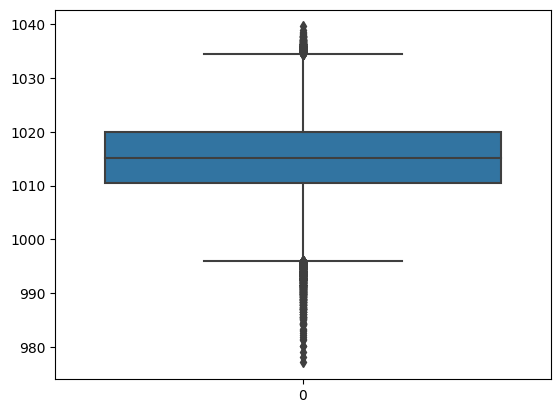

Mean: 1015.2579625879797 
Mode: 1015.5 
Median: 1015.2


In [15]:
count_stat(df, 'Pressure3pm', df.Pressure3pm.dtypes)

Пропущенні значення заміню **медіаною**, оскільки вона менш чутлива до викидів, які присутні. 

In [16]:
df['Pressure3pm'] = df['Pressure3pm'].fillna(df['Pressure3pm'].median())

`Pressure9am`
 - пропущенні значення = 9.76%

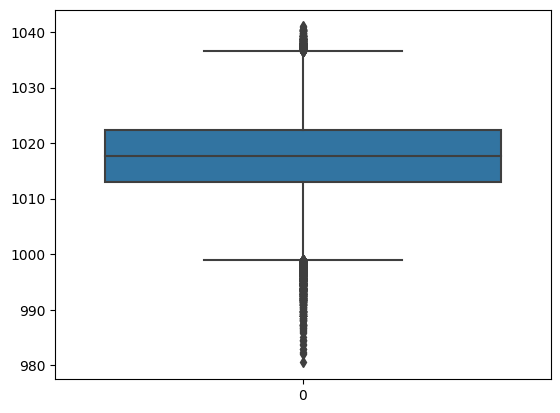

Mean: 1017.6545771543717 
Mode: 1016.4 
Median: 1017.6


In [43]:
count_stat(df, 'Pressure9am', df.Pressure9am.dtypes)

Пропущенні значення заміню **медіаною**, оскільки вона менш чутлива до викидів, які присутні. 

In [17]:
df['Pressure9am'] = df['Pressure9am'].fillna(df['Pressure9am'].median())

`WindDir9am`
 - пропущенні значення = 6.86%

WindDir9am
N      11266
SE      9116
E       8977
SSE     8901
NW      8471
S       8424
W       8207
SW      8160
NNE     7877
NNW     7782
ENE     7668
ESE     7518
NE      7477
SSW     7397
WNW     7100
WSW     6786
Name: count, dtype: int64


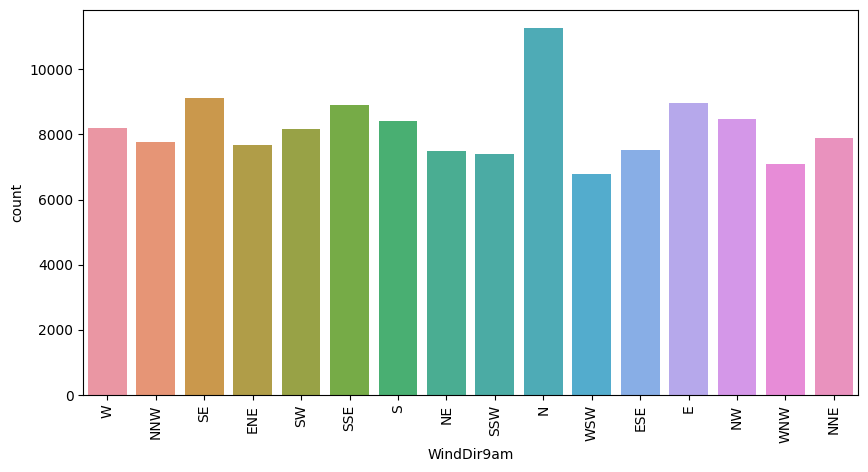

In [57]:
count_stat(df, 'WindDir9am', df.WindDir9am.dtypes)

Оскільки пропуски складають лише 6.86%, заповнення модою є найкращим варіантом.

In [18]:
df['WindDir9am'] = df['WindDir9am'].fillna(df['WindDir9am'].mode()[0])

`WindGustDir`
 - пропущенні значення = 6.51%

WindGustDir
W      9696
SE     9241
E      8985
N      8941
SSE    8905
S      8859
WSW    8802
SW     8702
SSW    8541
WNW    7960
NW     7939
ENE    7924
ESE    7244
NE     7002
NNW    6511
NNE    6372
Name: count, dtype: int64


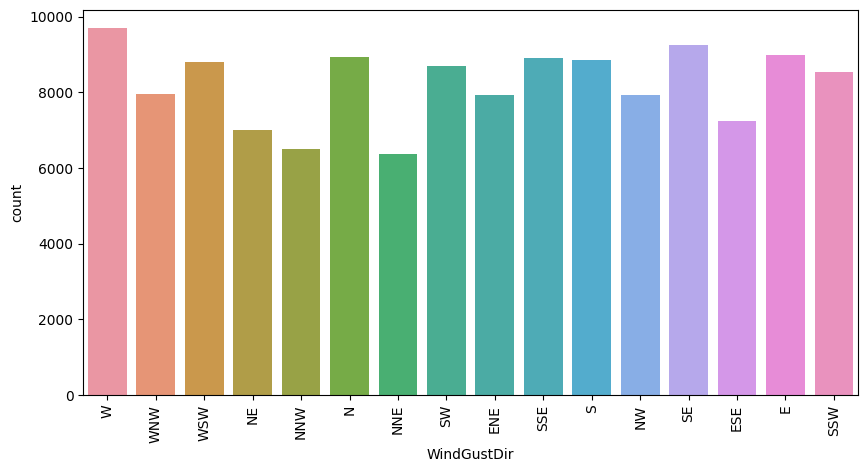

In [60]:
count_stat(df, 'WindGustDir', df.WindGustDir.dtypes)

Оскільки пропуски складають лише 6.51%, заповнення модою є найкращим варіантом.

In [19]:
df['WindGustDir'] = df['WindGustDir'].fillna(df['WindGustDir'].mode()[0])

`WindGustSpeed`
 - пропущенні значення = 6.47%

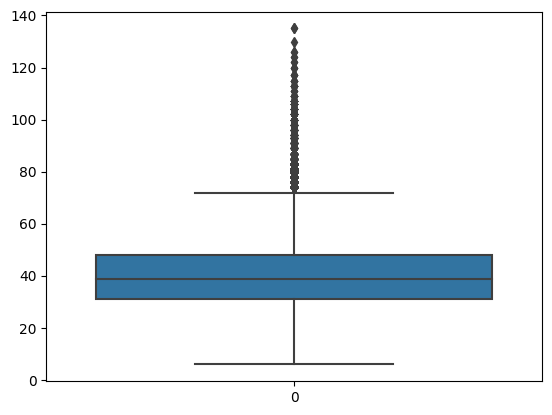

Mean: 39.97051988882308 
Mode: 35.0 
Median: 39.0


In [76]:
count_stat(df, 'WindGustSpeed', df.WindGustSpeed.dtypes)

Оскільки медіана (39.0) є близькою до середнього значення (39.97), а також враховуючи, що існують викиди (великий діапазон на верхній межі boxplot), медіана є найкращим варіантом для заповнення пропущених значень.

In [20]:
df['WindGustSpeed'] = df['WindGustSpeed'].fillna(df['WindGustSpeed'].median())

`WindDir3pm`
 - пропущенні значення = 2.61%

WindDir3pm
SE     10578
W       9810
S       9488
WSW     9231
SW      9104
SSE     9038
N       8593
WNW     8564
NW      8394
ESE     8311
E       8272
NE      8107
SSW     7945
NNW     7664
ENE     7645
NNE     6373
Name: count, dtype: int64


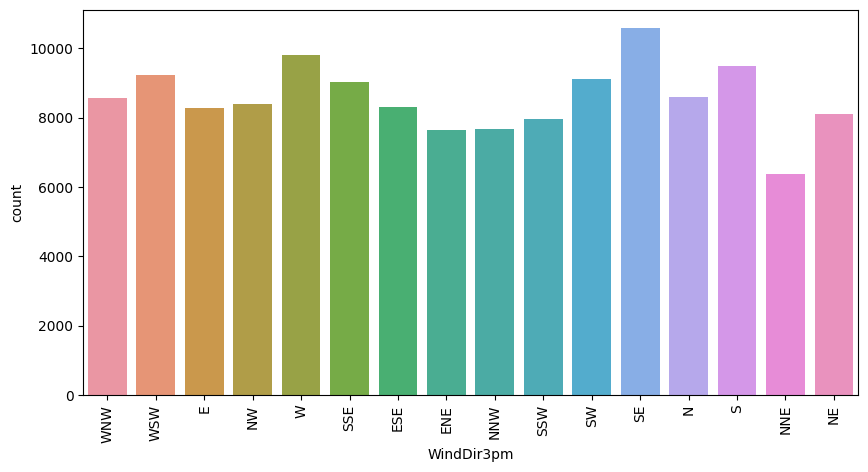

In [78]:
count_stat(df, 'WindDir3pm', df.WindDir3pm.dtypes)

Оскільки пропуски складають лише 2.61%, заповнення модою є найкращим варіантом.

In [21]:
df['WindDir3pm'] = df['WindDir3pm'].fillna(df['WindDir3pm'].mode()[0])

`Humidity3pm`
 - пропущенні значення = 2.49%

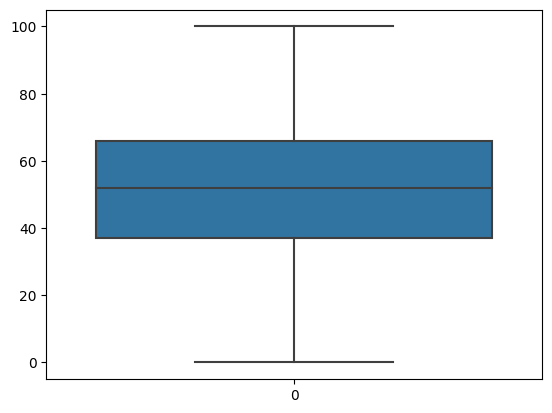

Mean: 51.44928834695453 
Mode: 52.0 
Median: 52.0


In [80]:
count_stat(df, 'Humidity3pm', df.Humidity3pm.dtypes)

Оскільки медіана, середнє та мода близькі, викиди відстуні, дані можна заповнити медіано, модою або середнім.

In [22]:
df['Humidity3pm'] = df['Humidity3pm'].fillna(df['Humidity3pm'].median())

`Temp3pm`
 - пропущенні значення = 1.86%

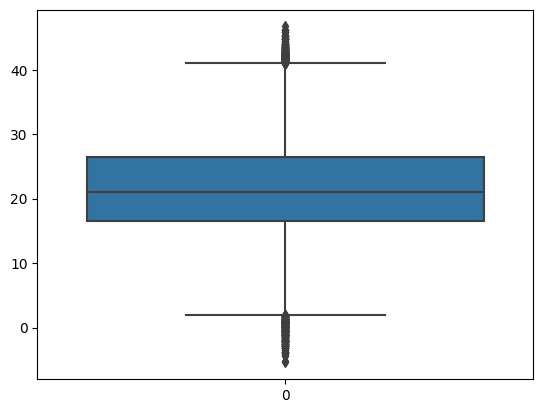

Mean: 21.69318269001107 
Mode: 20.0 
Median: 21.1


In [82]:
count_stat(df, 'Temp3pm', df.Temp3pm.dtypes)

Оскільки медіана (21.1) є близькою до середнього значення (21.69), а також враховуючи, що існують викиди, медіана є найкращим варіантом для заповнення пропущених значень.

In [23]:
df['Temp3pm'] = df['Temp3pm'].fillna(df['Temp3pm'].median())

`WindSpeed3pm`
 - пропущенні значення = 1.80%

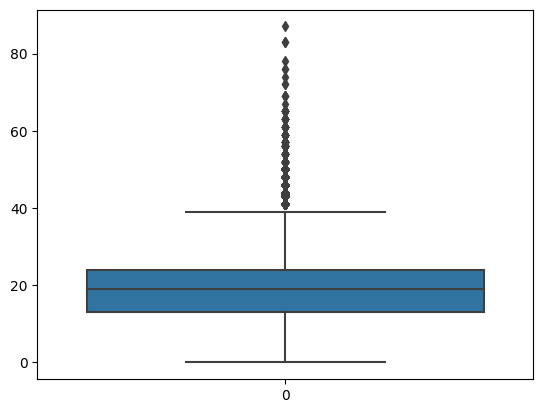

Mean: 18.631140782316862 
Mode: 13.0 
Median: 19.0


In [84]:
count_stat(df, 'WindSpeed3pm', df.WindSpeed3pm.dtypes)

Оскільки медіана (19.0) є близькою до середнього значення (18.63), а також враховуючи, що існують викиди (великий діапазон на верхній межі boxplot), медіана є найкращим варіантом для заповнення пропущених значень.

In [24]:
df['WindSpeed3pm'] = df['WindSpeed3pm'].fillna(df['WindSpeed3pm'].median())

`Humidity9am`
 - пропущенні значення = 1.08%

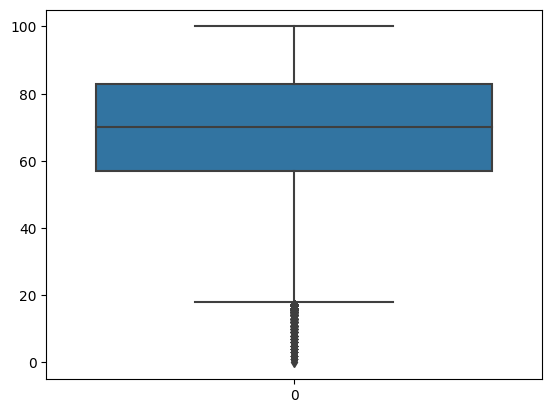

Mean: 68.82683277087672 
Mode: 99.0 
Median: 70.0


In [86]:
count_stat(df, 'Humidity9am', df.Humidity9am.dtypes)

Оскільки медіана (70.0) є близькою до середнього значення (68.82), а також враховуючи, що існують викиди (великий діапазон на нижній межі boxplot), медіана є найкращим варіантом для заповнення пропущених значень.

In [25]:
df['Humidity9am'] = df['Humidity9am'].fillna(df['Humidity9am'].median())

`WindSpeed9am`
 - пропущенні значення = 0.75%

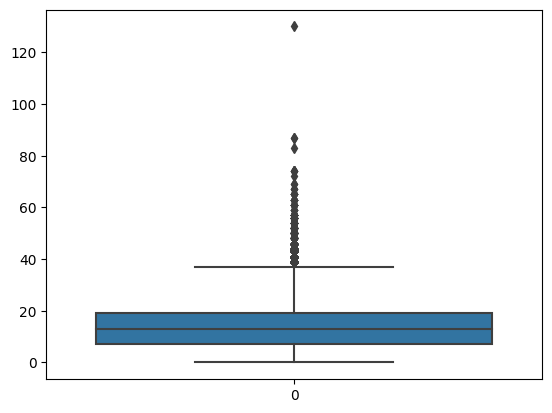

Mean: 13.990496092519967 
Mode: 9.0 
Median: 13.0


In [88]:
count_stat(df, 'WindSpeed9am', df.WindSpeed9am.dtypes)

Оскільки медіана (13.0) є близькою до середнього значення (13.99), а також враховуючи, що існують викиди (великий діапазон на верхній межі boxplot), медіана є найкращим варіантом для заповнення пропущених значень.

In [26]:
df['WindSpeed9am'] = df['WindSpeed9am'].fillna(df['WindSpeed9am'].median())

`Temp9am`
 - пропущенні значення = 0.47%

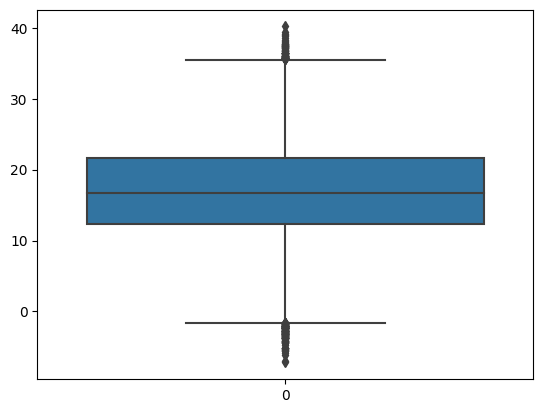

Mean: 16.98706638787991 
Mode: 17.0 
Median: 16.7


In [90]:
count_stat(df, 'Temp9am', df.Temp9am.dtypes)

Оскільки медіана (16.7) є близькою до середнього значення (16.98), а також враховуючи, що існують викиди (великий діапазон на верхній та нижній межах boxplot), медіана є найкращим варіантом для заповнення пропущених значень.

In [27]:
df['Temp9am'] = df['Temp9am'].fillna(df['Temp9am'].median())

`MinTemp`
 - пропущенні значення = 0.33%

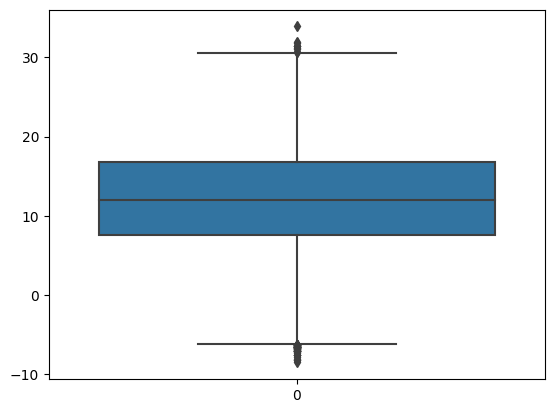

Mean: 12.18482386562048 
Mode: 9.6 
Median: 12.0


In [92]:
count_stat(df, 'MinTemp', df.MinTemp.dtypes)

Оскільки медіана (12.0) є близькою до середнього значення (12.18), а також враховуючи, що існують викиди, медіана є найкращим варіантом для заповнення пропущених значень.

In [28]:
df['MinTemp'] = df['MinTemp'].fillna(df['MinTemp'].median())

`MaxTemp`
 - пропущенні значення = 0.22%

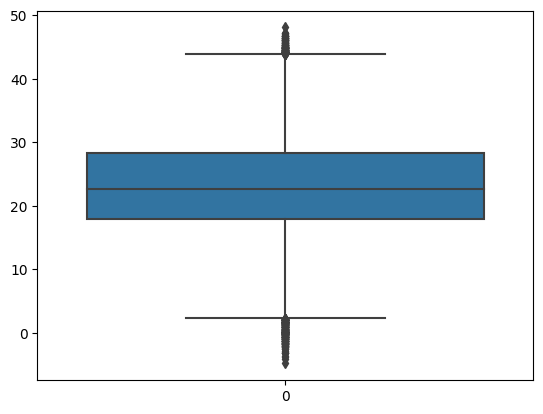

Mean: 23.235120301822324 
Mode: 20.0 
Median: 22.6


In [94]:
count_stat(df, 'MaxTemp', df.MaxTemp.dtypes)

Оскільки медіана (22.6) є близькою до середнього значення (23.23), а також враховуючи, що існують викиди, медіана є найкращим варіантом для заповнення пропущених значень.

In [29]:
df['MaxTemp'] = df['MaxTemp'].fillna(df['MaxTemp'].median())

In [30]:
df.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

Отже, тепер пропущенні значення відсутні.

## Побудова та налаштування моделей

Під час роботи з датами часто краще розділяти навчальні, валідаційні та тестові набори за часом, щоб модель навчалася на даних з минулого і оцінювалася на даних з майбутнього.

Для поточного набору даних використаю стовпець Date, щоб створити інший стовпець для року. Далі, оберу останні три роки для тестового набору.

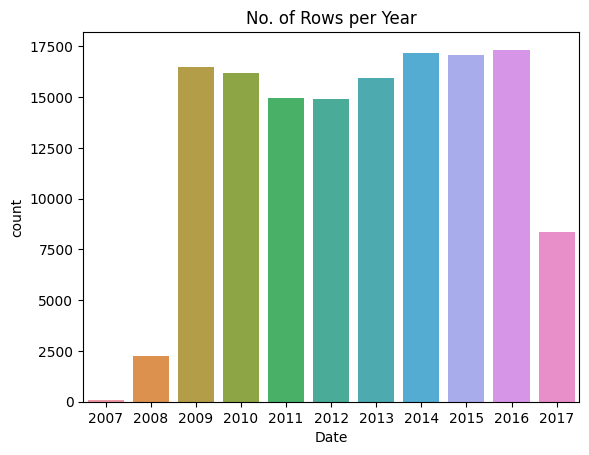

In [100]:
plt.title('No. of Rows per Year')
sns.countplot(x = pd.to_datetime(df.Date).dt.year);

In [103]:
# Розділення даних на тренувальний та тестовий набори
year = pd.to_datetime(df.Date).dt.year
train_df, test_df = df[year < 2015], df[year >= 2015]

input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

X_train, y_train = train_df[input_cols], train_df[target_col]
X_test, y_test   = test_df[input_cols], test_df[target_col]

# Визначення числових та категоріальних стовпців
numeric_cols     = X_train.select_dtypes(include = np.number).columns.tolist()[:-1]
categorical_cols = X_train.select_dtypes(include = 'object').columns.tolist()

# Створення пайплайну для кодування числових та категоріальних ознак
numeric_transformer = Pipeline(steps = [
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore'))
])

# Об'єднання трансформерів
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створення пайплайну для препроцесингу та створення моделі логістичної регресії та Random Forest
model_log_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver = 'liblinear'))
])

model_rf_pipeline = Pipeline(steps = [
    ('scaler', preprocessor),
    ('rf', RandomForestClassifier(n_estimators = 5,
                                  max_leaf_nodes = 16,
                                  n_jobs = -1,
                                  random_state = 42))
])

# Тренування моделей
model_log_pipeline.fit(X_train, y_train)
model_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Rainfall', 'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Temp9am']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainToday'])])),
                ('rf',
                 RandomForestClassifier(max_leaf_nodes=16, n_estimators=5,
                                        n_jobs=-1, random_state=42))])

In [106]:
# Прогнозування для моделі логістичної регресії
train_pred_logistic = model_log_pipeline.predict(X_train)
test_pred_logistic  = model_log_pipeline.predict(X_test)

# Прогнозування для моделі Random Forest
train_pred_rf = model_rf_pipeline.predict(X_train)
test_pred_rf  = model_rf_pipeline.predict(X_test)

ЛОГІСТИЧНА РЕГРЕСІЯ

Training accuracy: 84.97%
F1 score Training: 0.60%
Test accuracy: 84.56%
F1 score Test: 0.57%


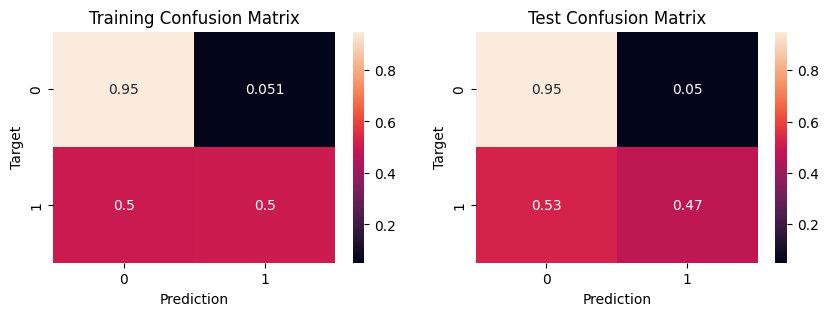

In [115]:
# Оцінка моделі логістичної регресії

print("ЛОГІСТИЧНА РЕГРЕСІЯ\n")
predict_and_plot(y_train, y_test, train_pred_logistic, test_pred_logistic)

RANDOM FOREST

Training
              precision    recall  f1-score   support

          No     0.8202    0.9812    0.8935     76190
         Yes     0.7906    0.2481    0.3777     21798

    accuracy                         0.8181     97988
   macro avg     0.8054    0.6147    0.6356     97988
weighted avg     0.8136    0.8181    0.7788     97988


Test
              precision    recall  f1-score   support

          No     0.8192    0.9794    0.8922     33396
         Yes     0.7606    0.2322    0.3557      9403

    accuracy                         0.8153     42799
   macro avg     0.7899    0.6058    0.6240     42799
weighted avg     0.8063    0.8153    0.7743     42799

Training accuracy: 81.81%
F1 score Training: 0.38%
Test accuracy: 81.53%
F1 score Test: 0.36%


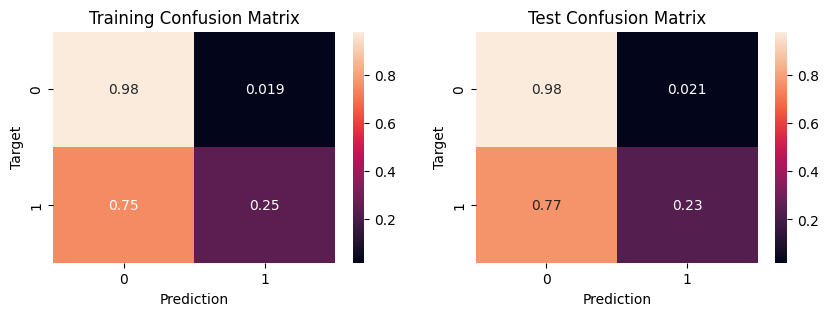

In [117]:
# Оцінка моделі Random Forest

print("RANDOM FOREST\n")
get_report(y_train, train_pred_rf, y_test, test_pred_rf)
predict_and_plot(y_train, y_test, train_pred_rf, test_pred_rf)

 - Логістична регресія має трохи вищу точність на тестовій вибірці (84.56%) порівняно з Random Forest (81.53%).
 - У логістичної регресії F1-score вищий, ніж у Random Forest на тренувальних і тестових даних (0.60 vs 0.38 на тренуванні та 0.57 vs 0.36 на тестуванні).

# Кластеризація даних

In [31]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No


In [32]:
df['Date'] = pd.to_datetime(df.Date).dt.year

num_cols = df.select_dtypes(include = 'number').columns.tolist()
cat_cols = df.select_dtypes(include = 'object').columns.tolist()
cat_cols.remove('RainTomorrow')

In [33]:
# розділення даних на два набори X та y

X = df.drop(columns = ['RainTomorrow'])
y = df['RainTomorrow']

# масштабування ознак
scaler = MinMaxScaler()
scaler.fit(X[num_cols])
X[num_cols] = scaler.transform(X[num_cols])

encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')
encoder.fit(X[cat_cols])
encoded_cols = list(encoder.get_feature_names_out(cat_cols))
X[encoded_cols] = encoder.transform(X[cat_cols])

X_scaled = X[num_cols + encoded_cols]

/tmp/ipykernel_1759/4096287988.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[encoded_cols] = encoder.transform(X[cat_cols])
/tmp/ipykernel_1759/4096287988.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[encoded_cols] = encoder.transform(X[cat_cols])
/tmp/ipykernel_1759/4096287988.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-f

Silhouette Coefficient for the data Dataset Clusters for k = 2: 0.110
Silhouette Coefficient for the data Dataset Clusters for k = 3: 0.047
Silhouette Coefficient for the data Dataset Clusters for k = 4: 0.048
Silhouette Coefficient for the data Dataset Clusters for k = 5: 0.054
Silhouette Coefficient for the data Dataset Clusters for k = 6: 0.058
Silhouette Coefficient for the data Dataset Clusters for k = 7: 0.047
Silhouette Coefficient for the data Dataset Clusters for k = 8: 0.058
Silhouette Coefficient for the data Dataset Clusters for k = 9: 0.060
Silhouette Coefficient for the data Dataset Clusters for k = 10: 0.064


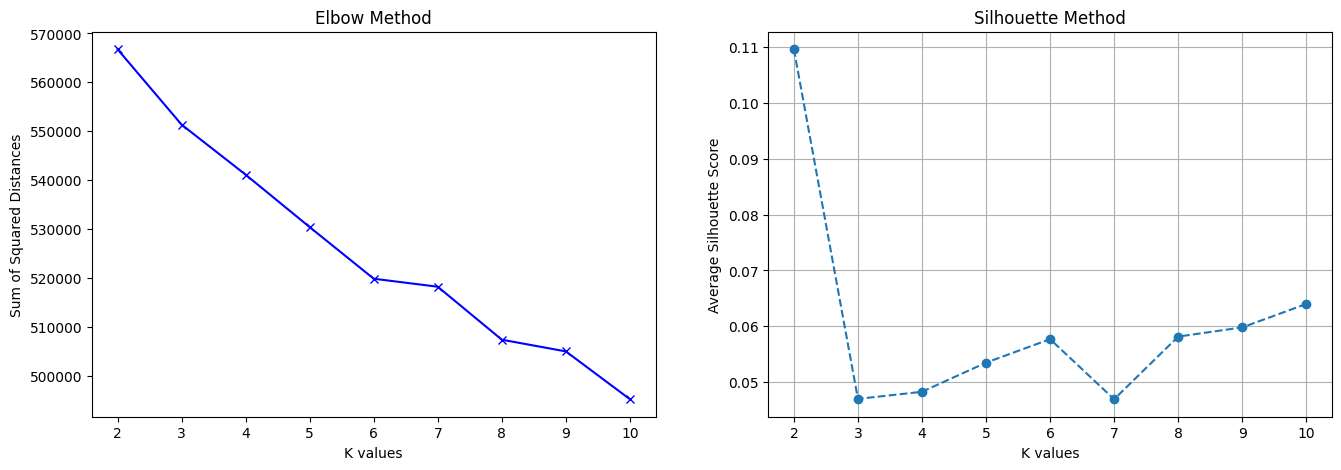

In [147]:
# визначення оптимальної кількості кластерів за допомогою методу ліктя та коефіцієнта середнього силуета

K = range(2, 11)
sum_of_squared_distances = []
silhouette_scores        = []

for k in K:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', n_init = 'auto', random_state = 170)
    
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)

    sum_of_squared_distances.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_avg)

    print(f'Silhouette Coefficient for the data Dataset Clusters for k = {k}: {silhouette_avg:.3f}')

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, marker = 'o', linestyle = '--')
plt.title('Silhouette Method')
plt.xlabel('K values')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.show()

Виходячи із результатів,найкращою кількістю кластерів може бути 2.

In [34]:
kmeans_2 = KMeans(n_clusters = 2, init = 'k-means++', n_init = 'auto', random_state = 170)
kmeans_2.fit(X_scaled)
labels_2 = kmeans_2.predict(X_scaled)

In [38]:
# Пониження розмірності за допомогою t-SNE
tsne    = TSNE(n_components = 2, random_state = 0)
tsne_df = pd.DataFrame(tsne.fit_transform(X_scaled), columns = ['x', 'y'])

# Додавання міток кластерів
tsne_df['labels'] = labels_2
tsne_df = pd.concat([tsne_df, X_scaled], axis=1)

# Побудова інтерактивного 2D-графіку
fig = px.scatter(
    tsne_df,
    x = 'x',
    y = 'y',
    color = 'labels',
    title = '2D Scatter Plot of Dataset with t-SNE (k = 2)'
)

# Оновлення макету та відображення графіку
fig.update_layout(title_x = 0.5)
fig.show()

Дані доволі гарно розділено на два класи.